## Load Dataset

In [41]:
import psycopg2
import pandas as pd
import json

conn = psycopg2.connect(
    dbname="scientilla",
    user="postgres",
    password="pwd",
    host="localhost",
    port=5444
)
cur = conn.cursor()

query = """
SELECT ri.id, ri.data
FROM research_item AS ri
JOIN research_item_type AS rit
    ON ri.research_item_type_id = rit.id
WHERE rit.type = 'publication'
ORDER BY ri.id
LIMIT 1000;
"""

df = pd.read_sql(query, conn)
print(df)

ids = df["id"].tolist()
data_array = df["data"].tolist()


       id                                               data
0    1786  {'doi': '10.1016/j.jconrel.2011.10.021', 'year...
1    1787  {'doi': '10.1002/adfm.202400982', 'year': '202...
2    1788  {'doi': '10.1016/j.jnucmat.2024.155121', 'year...
3    1789  {'doi': '10.1103/PhysRevB.94.165155', 'year': ...
4    1790  {'doi': '10.1039/c2jm15117k', 'year': '2012', ...
..    ...                                                ...
995  2781  {'doi': '10.1038/s41598-017-03882-8', 'year': ...
996  2782  {'doi': '10.1038/srep00630', 'year': '2012', '...
997  2783  {'doi': '10.1016/S0223-5234(99)80045-2', 'year...
998  2784  {'doi': '10.1209/0295-5075/25/5/005', 'year': ...
999  2785  {'doi': '10.1073/pnas.1121626109', 'year': '20...

[1000 rows x 2 columns]


/tmp/ipykernel_44566/1301059422.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Preprocessing

- **Remove unuseful prefixes** (e.g., Editorial, Preface, Erratum, Corrigendum, Introduction, Foreword) using a regex to clean titles.

- Extract and clean title and abstract text for each publication.

- **Discard low-information items**: if the cleaned title has ≤ 3 words and the abstract is missing, the document is excluded and its embedding will be set to NULL.

- Build the embedding text as:

    "<clean_title>. <abstract>" if an abstract exists,

    "<clean_title>." otherwise.

- Track IDs of valid and discarded documents to update the database accordingly.

In [33]:
import re

# Regex capturing titles starting with:
# - Editorial / Preface / Erratum / Corrigendum / Introduction / Foreword / Guest Editorial
# - with or without " to"
# - with or without ":"
# - with eventual spaces after
PATTERN = re.compile(
    r"^(Editorial|Preface|Erratum|Corrigendum|Introduction|Foreword|Guest Editorial)( to)?:?\s*",
    re.IGNORECASE
)

def clean_title(title: str) -> str:
    t = (title or "").strip()
    t = PATTERN.sub("", t).strip()
    return t

def build_clean_text_and_flags(item):
    """
    Returns:
      - text (string for the embedding) or None if to be filtered out
      - has_abstract (bool)
      - title_word_count (int)
    """
    title_raw = item.get("title") or ""
    abstract_raw = item.get("abstract") or ""

    title_clean = clean_title(title_raw)
    title_clean = title_clean.strip()

    # count words in title
    title_words = title_clean.split()
    title_word_count = len(title_words)

    # abstract cleaning
    abstract_clean = (abstract_raw or "").strip()
    has_abstract = bool(abstract_clean)

    # delete if title has less than three words and no abstract
    if title_word_count <= 3 and not has_abstract:
        return None, has_abstract, title_word_count

    # build text
    if has_abstract:
        text = f"{title_clean}. {abstract_clean}"
    else:
        text = f"{title_clean}."

    text = text.strip()
    if not text:
        return None, has_abstract, title_word_count

    return text, has_abstract, title_word_count

cleaned_texts = []
filtered_ids = []
has_abstract_flags = []
title_word_counts = []
bad_ids = []

for doc_id, item in zip(ids, data_array):
    text, has_abs, twc = build_clean_text_and_flags(item)
    if text is None:
        # document with short title and no abstract -> embedding NULL
        bad_ids.append(doc_id)
        continue

    cleaned_texts.append(text)
    filtered_ids.append(doc_id)
    has_abstract_flags.append(has_abs)
    title_word_counts.append(twc)

print(f"Number of docs before filtering: {len(ids)}")
print(f"Number of docs after filtering (with embeddings): {len(filtered_ids)}")
print(f"Number of docs set to NULL embedding: {len(bad_ids)}")



Number of docs before filtering: 1000
Number of docs after filtering (with embeddings): 993
Number of docs set to NULL embedding: 7


## Dataset Embedding Generation

In [34]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_embeddings = model.encode(
    cleaned_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)

#### Save to db

- All documents filtered out during preprocessing (short titles with no abstract) are updated in the database with embedding = NULL.

- Embeddings are computed only for the remaining valid documents.

In [ ]:
# set embeddings to NULL for filtered out documents
if bad_ids:
    null_sql = """
    UPDATE research_item
    SET embedding = NULL
    WHERE id = ANY(%s);
    """
    cur.execute(null_sql, (bad_ids,))

# store embeddings for the remaining documents
update_sql = """
UPDATE research_item
SET embedding = %s::vector
WHERE id = %s;
"""

for rid, emb in zip(filtered_ids, doc_embeddings):
    emb_list = emb.tolist()
    emb_str = "[" + ",".join(str(float(x)) for x in emb_list) + "]"
    cur.execute(update_sql, (emb_str, rid))

conn.commit()
cur.close()

print("Embeddings stored in research_item.embedding (bad docs set to NULL).")

Embeddings stored in research_item.embedding (bad docs set to NULL).


### Clustering

/tmp/ipykernel_44566/775798925.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


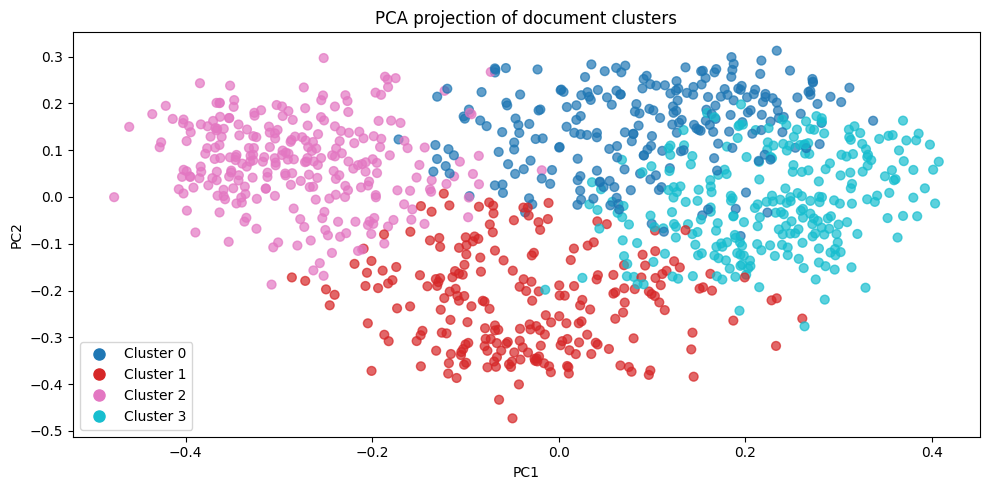

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = cleaned_texts  # extract titles

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(doc_embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

# Print documents grouped by cluster
# for c in range(n_clusters):
#     print(f"\n=== Cluster {c} ===")
#     indices = np.where(labels == c)[0]
#     for idx in indices:
#         print(f"- {titles[idx]}")


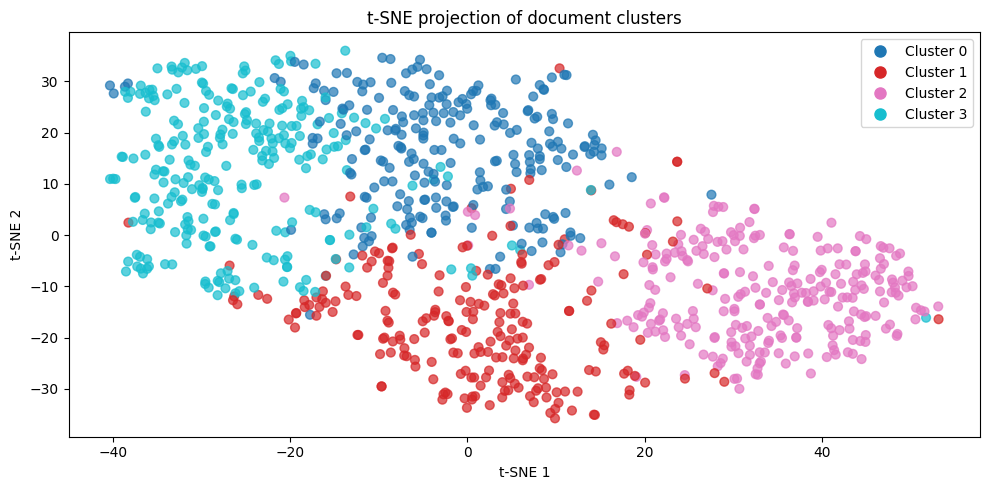

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


## Testing

#### From db

In [39]:

def embedding_to_pgvector_str(vec):
    """From np.array to string '[v1,v2,...]' for ::vector."""
    return "[" + ",".join(str(float(x)) for x in vec.tolist()) + "]"

def search(query, top_k=5):
    # query embedding
    query = (query or "").strip()
    if not query:
        print("Empty query.")
        return
    
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    q_emb_str = embedding_to_pgvector_str(q_emb)

    # SQL query with pgvector cosine distance
    sql = """
    WITH q AS (
        SELECT %s::vector AS emb
    )
    SELECT
        ri.id,
        ri.data,
        ri.embedding <=> q.emb AS distance
    FROM research_item AS ri
    JOIN research_item_type AS rit
        ON ri.research_item_type_id = rit.id
    JOIN q
        ON TRUE
    WHERE rit.type = 'publication'
      AND ri.embedding IS NOT NULL
    ORDER BY ri.embedding <=> q.emb
    LIMIT %s;
    """

    with conn.cursor() as cur:
        cur.execute(sql, (q_emb_str, top_k))
        rows = cur.fetchall()

    print(f"\n=== Query: {query!r} ===")

    for i, (doc_id, data_json, distance) in enumerate(rows, start=1):
        # Convert distance to similarity score
        score = 1.0 - float(distance)

        # simple preview from stored data
        title = (data_json.get("title") or "").strip()
        abstract = (data_json.get("abstract") or "").strip()
        preview = (title + ". " + abstract).strip()
        preview = preview[:200] + ("..." if len(preview) > 200 else "")
        
        print(f"\n[{i}] id={doc_id}  score={score:.3f}")
        print(f"     text: {preview}")


In [43]:
test_queries = ['renewable energies','heart diseases', 'cardiology', 'nature','biology']

for q in test_queries:
    search(q, top_k=5)


=== Query: 'renewable energies' ===

[1] id=2360  score=0.735
     text: Innovative micro- and nanostructured materials and devices for energy applications.

[2] id=2465  score=0.722
     text: Cheap and easily processable electrode/electrolytes for next-generation sodium-ion batteries. Electrochemical energy storage is of increasing importance to allow large-scale integration of intermitten...

[3] id=2596  score=0.714
     text: Charger-mediated energy transfer for quantum batteries: An open-system approach. The energy charging of a quantum battery is analyzed in an open quantum setting, where the interaction between the batt...

[4] id=2782  score=0.701
     text: Optimizing functional network representation of multivariate time series. By combining complex network theory and data mining techniques, we provide objective criteria for optimization of the function...

[5] id=2020  score=0.694
     text: The lattice Boltzmann equation: A new tool for computational fluid-dynamics. We pr